In [20]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, root_mean_squared_error,mean_absolute_error,r2_score,mean_absolute_percentage_error
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [21]:
"""# Reading the required files"""

data = pd.read_csv('NSE(3).csv')


data['Vol.'] = data['Vol.'].replace({'M': '*1e6', 'B': '*1e9'}, regex=True)

# Replace NaN with a placeholder (e.g., np.nan) before applying eval
data['Vol.'] = data['Vol.'].map(lambda x: pd.eval(x) if pd.notna(x) else np.nan).astype(float)

# Display cleaned data
print(data.head())

data.shape


         Date      Close       Open       High        Low         Vol.  \
0  20-12-2024  101129.09  101247.53  101350.47  100796.84  513560000.0   
1  19-12-2024  101248.02  100482.73  101290.57  100482.73  400440000.0   
2  18-12-2024  100477.46  100050.94  100477.46  100050.94  389700000.0   
3  17-12-2024  100050.94   99927.85  100086.21   99791.29  477880000.0   
4  16-12-2024   99922.63   99389.34  100086.80   99389.15  740890000.0   

  Change %  
0   -0.12%  
1    0.77%  
2    0.43%  
3    0.13%  
4    0.55%  


(2059, 7)

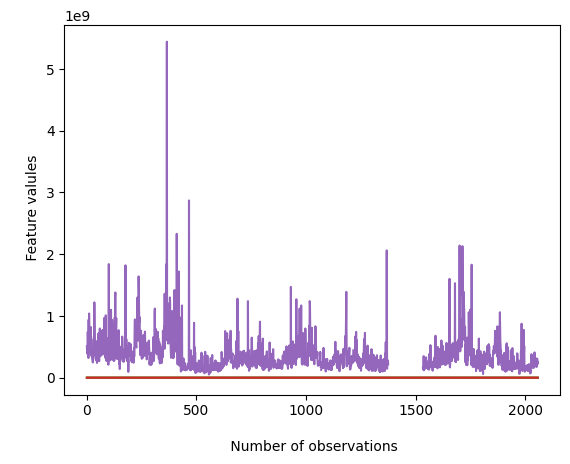

In [22]:

# Non-Stationary TimeSeries test using visualization
aaa=['Open', 'High', 'Low', 'Close', 'Vol.']
plt.plot(data[aaa])
plt.xlabel('\n Number of observations')
plt.ylabel('\n Feature valules')
plt.show()


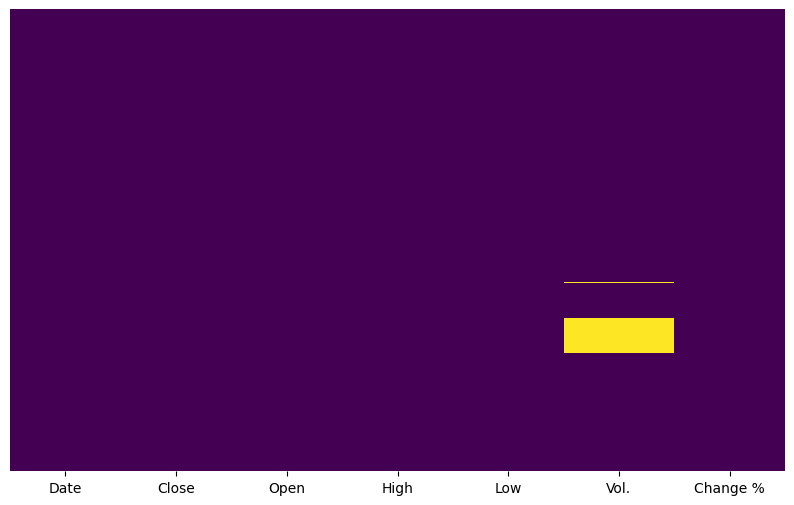

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize missing data as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data.isna(), cbar=False, cmap='viridis', yticklabels=False)
plt.show()


In [24]:
missing_percentage = (data.isna().sum() / len(data)) * 100
print(missing_percentage)


Date        0.000000
Close       0.000000
Open        0.000000
High        0.000000
Low         0.000000
Vol.        7.916464
Change %    0.000000
dtype: float64


In [25]:
data['Vol.'] = data['Vol.'].interpolate(method='linear')


In [26]:
missing_percentage = (data.isna().sum() / len(data)) * 100
print(missing_percentage)


Date        0.0
Close       0.0
Open        0.0
High        0.0
Low         0.0
Vol.        0.0
Change %    0.0
dtype: float64


In [27]:
X = data.values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]

X1 = pd.DataFrame(X1)  
X2 = pd.DataFrame(X2)

X1 = X1.apply(pd.to_numeric, errors='coerce')
X2 = X2.apply(pd.to_numeric, errors='coerce')

mean1, mean2 = X1.mean().mean(), X2.mean().mean() 
var1, var2 = X1.var().mean(), X2.var().mean() 
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))


mean1=80262945.351515, mean2=59894920.077337
variance1=20392842179870416.000000, variance2=9544521366813294.000000


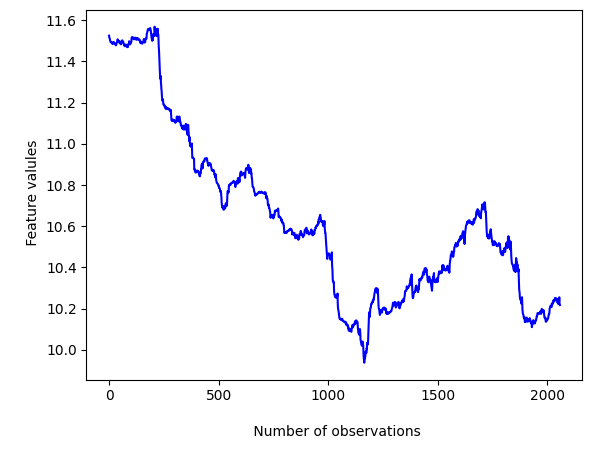

In [28]:

# Stationary TimeSeries test using visualization
numeric_data = data.select_dtypes(include=[np.number])
log_data = np.log(numeric_data)
plt.plot(log_data['Open'], 'b')
plt.xlabel('\n Number of observations')
plt.ylabel('\n Feature valules')
plt.show()

log_data = log_data.replace([np.inf, -np.inf], np.nan)
log_data = log_data.fillna(log_data.mean())



In [29]:

# Stationary Test using Summary Statistics
X = log_data.values
X = np.log(X)
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))
Target_data = log_data['Close']
Train_data = log_data.drop(labels=['Close'], axis=1)


Target_data.head()

MinMax_Scaler = MinMaxScaler()
MinMax_feature_transform = MinMax_Scaler.fit_transform(Train_data)
MinMax_feature_transform = pd.DataFrame(MinMax_feature_transform, columns=Train_data.columns, index=Train_data.index)
scaled_target = MinMax_Scaler.fit_transform(Target_data.values.reshape(-1, 1))
scaled_features_df = pd.DataFrame(MinMax_feature_transform, columns=Train_data.columns, index=Train_data.index)



mean1=2.509269, mean2=2.459700
variance1=0.055445, variance2=0.063715


In [30]:
# Define a function to create input-output sequences for sliding window
def create_sequences(scaled_target, window_size):
    X, y = [], []
    for i in range(len(scaled_target) - window_size):
        X.append(scaled_target[i:i + window_size])  # Input: window_size time steps
        y.append(scaled_target[i + window_size])    # Output: the next time step
    return np.array(X), np.array(y)

# Apply sliding window
window_size = 60
X, y = create_sequences(scaled_target, window_size)


In [31]:

# Split the data
timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(MinMax_feature_transform):
        X_train, X_test = MinMax_feature_transform[:len(train_index)], MinMax_feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = Target_data[:len(train_index)].values.ravel(), Target_data[len(train_index): (len(train_index)+len(test_index))].values.ravel()


In [32]:

"""# LSTM"""

# fix random seed for reproducibility
tf.random.set_seed(7)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

#Process the data for LSTM
trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

trainY =np.array(y_train)


(1872, 4) (187, 4) (1872,) (187,)


In [33]:

#Building the LSTM Model
model = Sequential()
model.add(LSTM(units=50, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
#model.add(LSTM(units=50, dropout=0.2, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adamax')

history = model.fit(X_train, y_train, epochs=100, batch_size=1)

lstm_prediction = model.predict(X_test)
print(len(lstm_prediction))


c:\Users\a\Desktop\projects\LSTM\japan\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
1872/1872 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 67.3389
Epoch 2/100
1872/1872 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 4.0983
Epoch 3/100
1872/1872 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.0387
Epoch 4/100
1872/1872 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.2732
Epoch 5/100
1872/1872 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1690
Epoch 6/100
1872/1872 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1034
Epoch 7/100
1872/1872 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0528
Epoch 8/100
1872/1872 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0194
Epoch 9/100
1872/1872 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0040
Epoch 10/100
1872/1872 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0011
Epoch 11/100
1872/1872 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 4.7119e-04
Epoch 12/100
1872/1872 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2.0539e-04
Epoch 13/100
1872/1872 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.3706e-04
Epoch 14/100
1872/1872 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.2174e-0

MSE:  4.0998e-05
RMSE:  0.006402968
MAE 0.005528818
MAPE 0.000543057


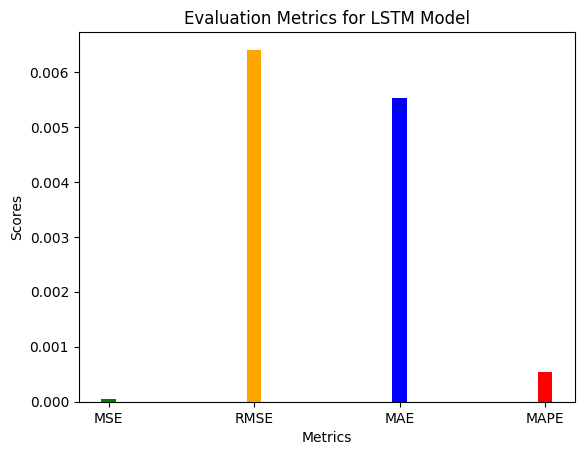

In [34]:
MSE = round(mean_squared_error(y_test, lstm_prediction), 9)
RMSE = round(np.sqrt(MSE), 9)  
MAE = round(mean_absolute_error(y_test, lstm_prediction), 9)
MAPE=round(mean_absolute_percentage_error(y_test, lstm_prediction), 9)
print('MSE: ', MSE)
print('RMSE: ', RMSE)
print('MAE', MAE)
print('MAPE', MAPE)

x = [0, 1, 2, 3]
plt.bar(x[0], MSE, width=0.1, color='GREEN', label='MSE')
plt.bar(x[1], RMSE, width=0.1, color='orange', label='RMSE')
plt.bar(x[2], MAE, width=0.1, color='blue', label='MAE')
plt.bar(x[3], MAPE, width=0.1, color='RED', label='MAPE')
plt.xticks(x, ['MSE', 'RMSE', 'MAE','MAPE'])
plt.xlabel("Metrics")
plt.ylabel("Scores")
plt.title("Evaluation Metrics for LSTM Model")
plt.show()


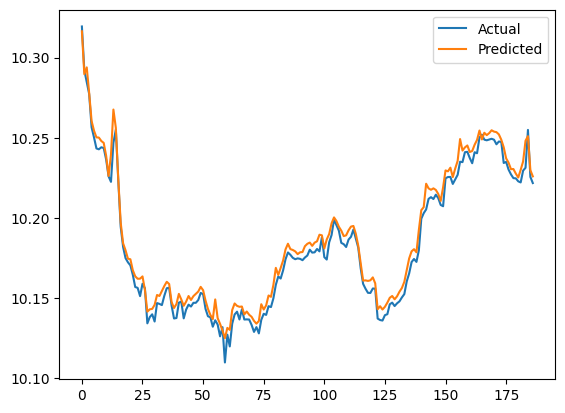

In [35]:
plt.plot(y_test, label='Actual')
plt.plot(lstm_prediction, label='Predicted')
plt.legend()
plt.show()
